<a href="https://colab.research.google.com/github/GerthDALA/bertin-dala-ML/blob/master/Diamond.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Analysis Pipeline

Le but du projet est une initiation au machine learning.

Nous allons tenté de prédire les prix de diamants en fonction de leurs caractéristiques (taille, couleur, carat, clarté..).

Le dataset est disponible [ici](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfInstances=between_10000_100000&qualities.NumberOfFeatures=between_10_100&qualities.NumberOfClasses=lte_1&id=42225)

Des exemples de code sont disponibles sur Kaggle ([exemples](https://www.kaggle.com/datasets/resulcaliskan/diamonds/code))

Nous nous baserons sur des exemples vus en cours pour les méthodes utilisées.

#Import

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#Load Dataset

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dataset_analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load the dataset from OpenML
from sklearn.datasets import fetch_openml

def load_data():
    dataset_id = 42225  # Corrected to an integer
    data = fetch_openml(data_id=dataset_id, as_frame=True)
    return data

# Load data
data = load_data()
df = data['data']
df['target'] = data['target']
df.rename(columns={'target': 'price'}, inplace=True)

## --- Exploratory Data Analysis (EDA) --- #

In [ ]:
# Metadata
print("Number of Instances:", df.shape[0])
print("Number of Features:", df.shape[1])
print("Feature Types:")
print(df.dtypes)

# Null or NA values analysis
print("\nNull values per feature:")
print(df.isnull().sum())

Number of Instances: 53940
Number of Features: 10
Feature Types:
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
price         int64
dtype: object

Null values per feature:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64


In [ ]:

df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


#Display dataset head Info

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


In [ ]:
df.describe()

,carat,depth,table,x,y,z,price
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734,3932.799722
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699,3989.439738
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,950.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,2401.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5324.250000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,18823.000000


Saving figure attribute_histogram_plots


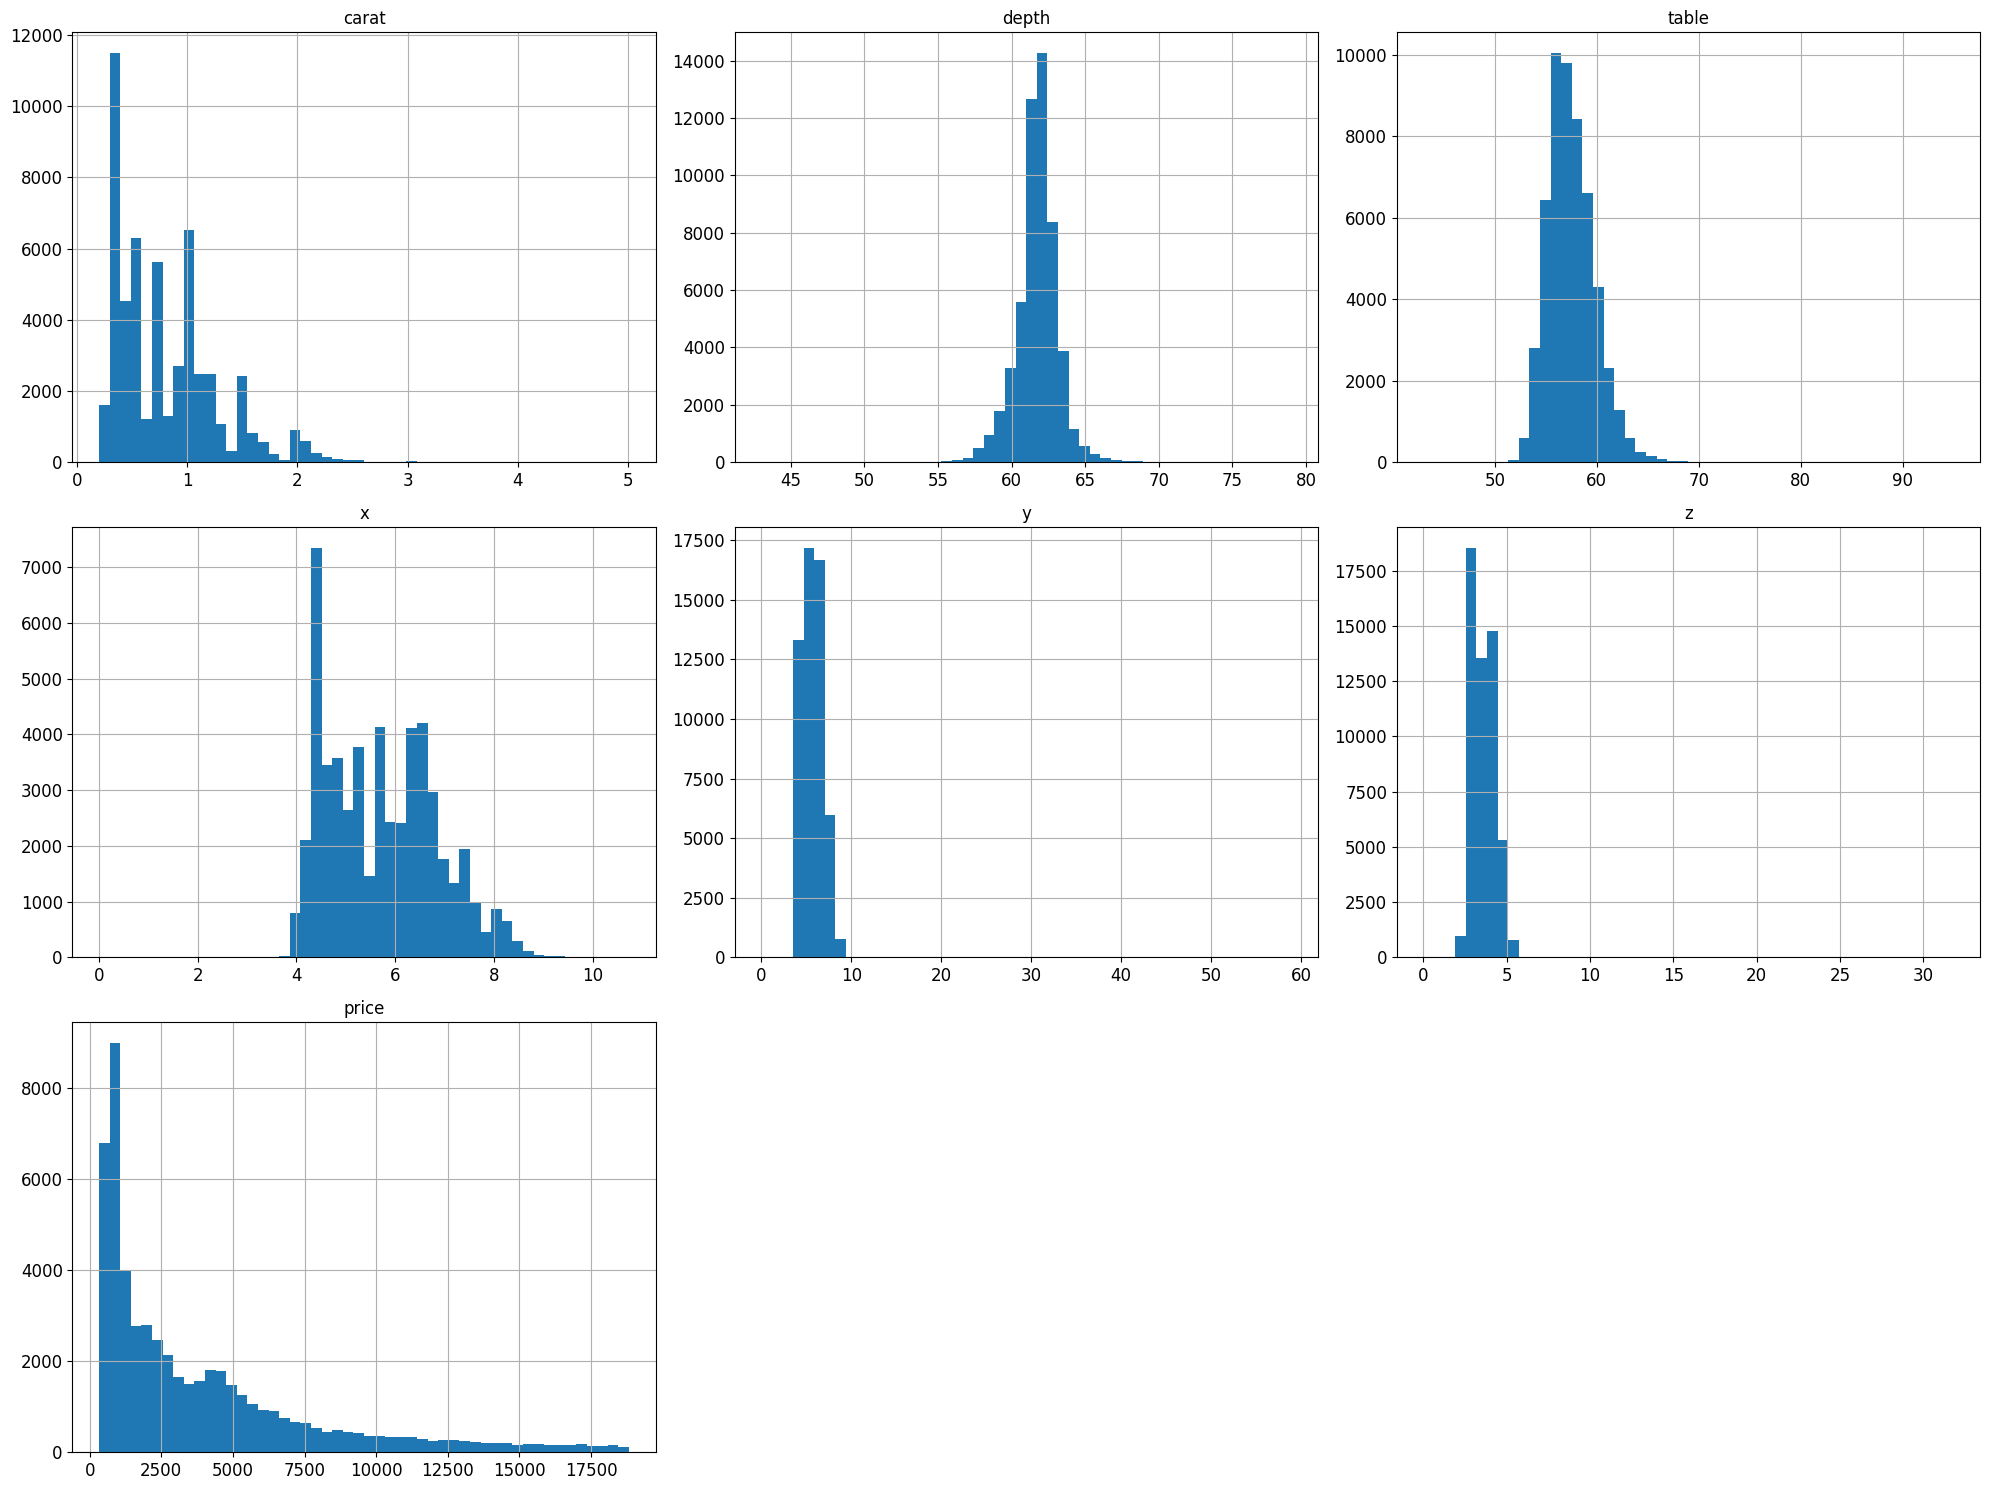

In [ ]:
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

#Create a Test Set

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)
print("Train dataset length")
print(len(train_set))

Train dataset length
43152


In [ ]:
print("Test dataset length")
print(len(test_set))

Test dataset length
10788


In [ ]:
test_set.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
1388,0.24,Ideal,G,VVS1,62.1,56.0,3.97,4.00,2.47,559
50052,0.58,Very Good,F,VVS2,60.0,57.0,5.44,5.42,3.26,2201
41645,0.40,Ideal,E,VVS2,62.1,55.0,4.76,4.74,2.95,1238
42377,0.43,Premium,E,VVS2,60.8,57.0,4.92,4.89,2.98,1304
17244,1.55,Ideal,E,SI2,62.3,55.0,7.44,7.37,4.61,6901


On suppose que le carat est un attribut très important dans la prédiction de prix du diamant.

<Axes: >

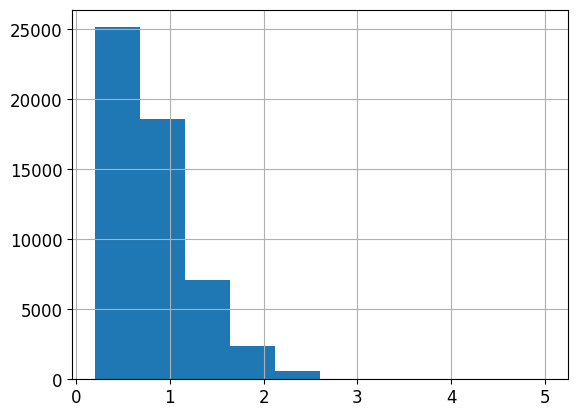

In [ ]:
df["carat"].hist()

In [ ]:
df["carat_cat"] = pd.cut(df["carat"],
                               bins=[0., 0.3, 0.5, 0.7, 1., 2., np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [ ]:
df["carat_cat"].value_counts()

,count
carat_cat,
5,15613
2,14729
4,9276
3,8230
1,4203
6,1889


<Axes: >

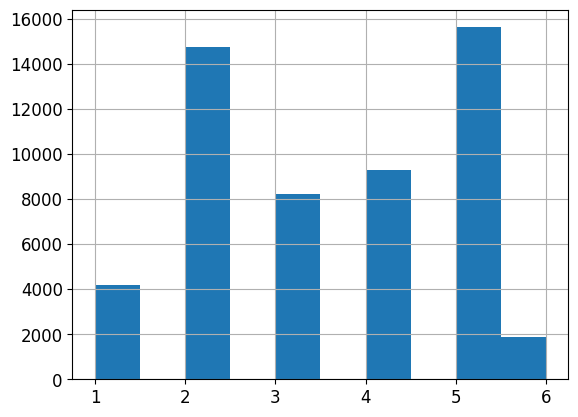

In [ ]:
df["carat_cat"].hist()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["carat_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [ ]:
strat_test_set["carat_cat"].value_counts() / len(strat_test_set)

,count
carat_cat,
5,0.289488
2,0.273081
4,0.171950
3,0.152577
1,0.077864
6,0.035039


In [ ]:
df["carat_cat"].value_counts() / len(df)

,count
carat_cat,
5,0.289451
2,0.273063
4,0.171969
3,0.152577
1,0.077920
6,0.035020


In [ ]:
def carat_cat_proportions(data):
    return data["carat_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": carat_cat_proportions(df),
    "Stratified": carat_cat_proportions(strat_test_set),
    "Random": carat_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
carat_cat,,,,,
1,0.077920,0.077864,0.083797,7.542232,-0.071378
2,0.273063,0.273081,0.271598,-0.536357,0.006789
3,0.152577,0.152577,0.148128,-2.916160,0.000000
4,0.171969,0.171950,0.174268,1.336783,-0.010781
5,0.289451,0.289488,0.287078,-0.819830,0.012810
6,0.035020,0.035039,0.035132,0.317628,0.052938


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("carat_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [ ]:
diamond_train_set = strat_train_set.copy()
diamond_test_set = strat_test_set.copy()


diamond_train_set.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
10250,1.00,Premium,F,SI2,61.4,61.0,6.47,6.40,3.95,4749
5339,1.00,Ideal,I,SI2,60.9,57.0,6.43,6.47,3.93,3811
19461,1.02,Ideal,G,VVS2,59.2,58.0,6.56,6.62,3.90,8107
16689,0.31,Ideal,H,SI1,61.3,55.0,4.36,4.41,2.69,421
40074,0.30,Ideal,F,VVS1,62.1,55.0,4.32,4.31,2.68,1114


## Looking for Correlations

In [ ]:
def one_hot_encode_and_impute(df):
  categorical_features = ['cut', 'clarity', 'color']

  categorical_imputer = SimpleImputer(strategy="most_frequent")
  df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

  one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use dense output
  one_hot_encoded = pd.DataFrame(
      one_hot_encoder.fit_transform(df[categorical_features]),
      columns=one_hot_encoder.get_feature_names_out(categorical_features),
      index=df.index,
  )

  df = df.drop(columns=categorical_features).join(one_hot_encoded)

  print("One-hot encoding applied to 'cut', 'clarity', and 'color'. Processed DataFrame:")
  print(df.head())
  return df

In [ ]:
diamond_train_set = one_hot_encode_and_impute(diamond_train_set)
corr_matrix = diamond_train_set.corr()

One-hot encoding applied to 'cut', 'clarity', and 'color'. Processed DataFrame:
       carat  depth  table     x     y     z  price  cut_Fair  cut_Good  \
10250   1.00   61.4   61.0  6.47  6.40  3.95   4749       0.0       0.0   
5339    1.00   60.9   57.0  6.43  6.47  3.93   3811       0.0       0.0   
19461   1.02   59.2   58.0  6.56  6.62  3.90   8107       0.0       0.0   
16689   0.31   61.3   55.0  4.36  4.41  2.69    421       0.0       0.0   
40074   0.30   62.1   55.0  4.32  4.31  2.68   1114       0.0       0.0   

       cut_Ideal  ...  clarity_VS2  clarity_VVS1  clarity_VVS2  color_D  \
10250        0.0  ...          0.0           0.0           0.0      0.0   
5339         1.0  ...          0.0           0.0           0.0      0.0   
19461        1.0  ...          0.0           0.0           1.0      0.0   
16689        1.0  ...          0.0           0.0           0.0      0.0   
40074        1.0  ...          0.0           1.0           0.0      0.0   

       color_E  co

In [ ]:
corr_matrix["price"].sort_values(ascending=False)

,price
price,1.000000
carat,0.921751
x,0.884581
z,0.873864
y,0.860315
table,0.129558
clarity_SI2,0.128958
color_I,0.098717
cut_Premium,0.095956
color_J,0.079288


On remarque que le carat est fortement correlé au prix du diamant, du même que la taille.

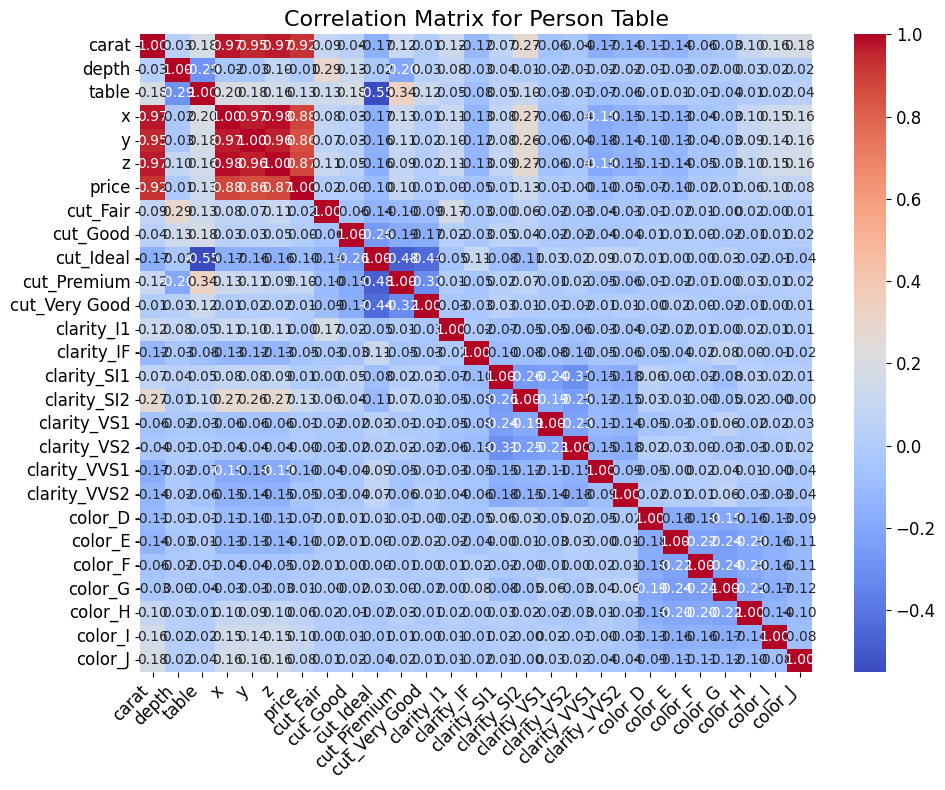

In [ ]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title("Correlation Matrix for Person Table", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()


## Experimenting with Attribute Combinations

In [ ]:
diamond_train_set["volume"] = diamond_train_set["x"] * diamond_train_set["y"] * diamond_train_set["z"]

In [ ]:
corr_matrix = diamond_train_set.corr()
corr_matrix["price"].sort_values(ascending=False)

,price
price,1.000000
carat,0.921751
volume,0.898558
x,0.884581
z,0.873864
y,0.860315
table,0.129558
clarity_SI2,0.128958
color_I,0.098717
cut_Premium,0.095956


In [ ]:
max(diamond_train_set["volume"])

3840.5980600000003

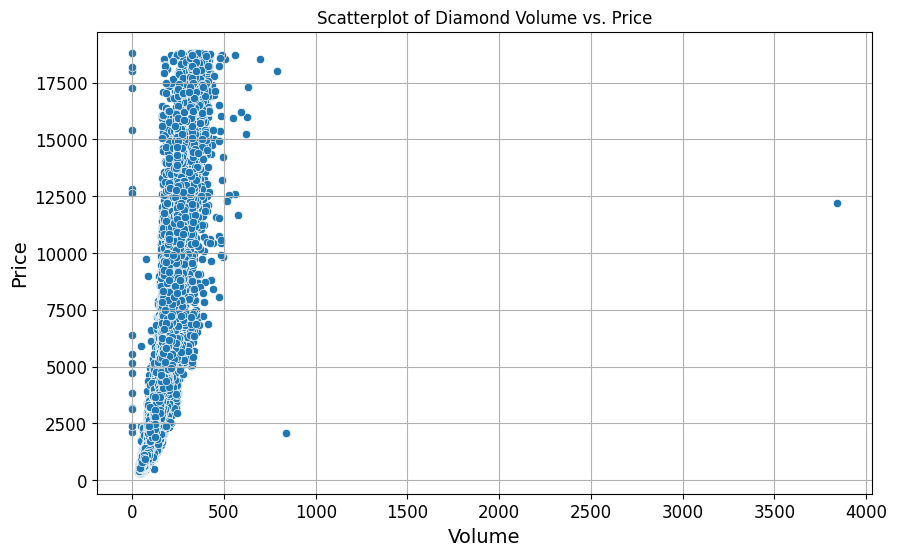

In [ ]:
# Scatterplot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='volume', y='price', data=diamond_train_set)
plt.title("Scatterplot of Diamond Volume vs. Price")
plt.xlabel("Volume")
plt.ylabel("Price")
plt.grid(True)
plt.show()


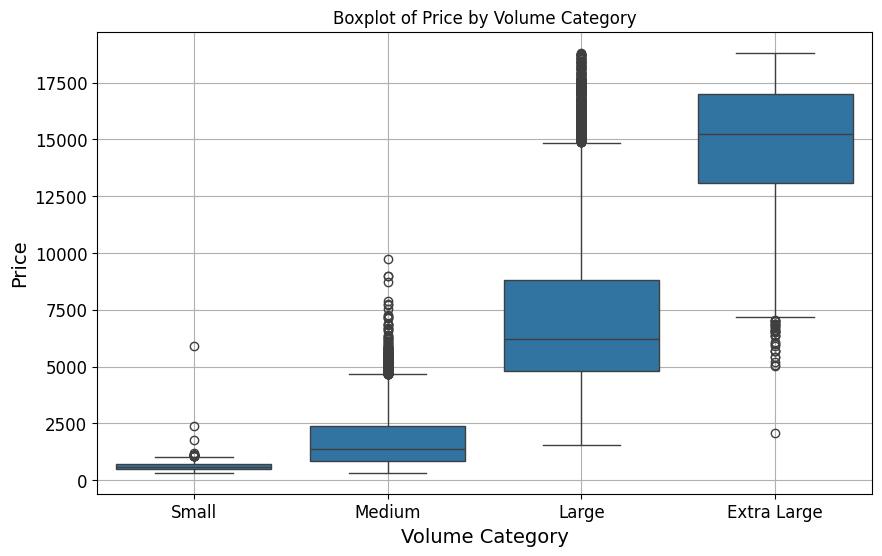

In [ ]:
# Define bins for volume
volume_bins = [0, 50, 150, 300, np.inf]
volume_labels = ['Small', 'Medium', 'Large', 'Extra Large']
diamond_train_set['volume_category'] = pd.cut(diamond_train_set['volume'], bins=volume_bins, labels=volume_labels)

# Boxplot to examine how volume categories influence price
plt.figure(figsize=(10, 6))
sns.boxplot(x='volume_category', y='price', data=diamond_train_set)
plt.title("Boxplot of Price by Volume Category")
plt.xlabel("Volume Category")
plt.ylabel("Price")
plt.grid(True)
plt.show()

diamond_train_set = diamond_train_set.drop('volume_category', axis = 1)



On remarque ici que le volume est bien plus correlé au prix qu'au valeurs de x, y and z vue individuelment.

#Prepare the Data for Machine Learning Algorithms

Le dataset test_set n'étant pas standardisé, doit être standardisé pour être identique au diamond_train_set.



In [ ]:
diamond_test_set = one_hot_encode_and_impute(diamond_test_set)
diamond_test_set["volume"] = diamond_test_set["x"] * diamond_test_set["y"] * diamond_test_set["z"]


One-hot encoding applied to 'cut', 'clarity', and 'color'. Processed DataFrame:
       carat  depth  table     x     y     z  price  cut_Fair  cut_Good  \
19410   1.22   62.0   55.0  6.91  6.83  4.26   8067       0.0       0.0   
47783   0.52   61.3   56.0  5.18  5.20  3.18   1897       0.0       0.0   
35611   0.30   61.1   61.0  4.29  4.32  2.63    473       0.0       0.0   
20414   1.21   62.6   56.0  6.81  6.77  4.25   8774       0.0       0.0   
11479   0.92   61.7   57.0  6.24  6.27  3.86   5014       0.0       0.0   

       cut_Ideal  ...  clarity_VS2  clarity_VVS1  clarity_VVS2  color_D  \
19410        1.0  ...          1.0           0.0           0.0      0.0   
47783        1.0  ...          0.0           0.0           1.0      0.0   
35611        0.0  ...          1.0           0.0           0.0      0.0   
20414        1.0  ...          0.0           0.0           0.0      0.0   
11479        1.0  ...          0.0           0.0           0.0      0.0   

       color_E  co

In [ ]:
diamond_test_set.describe()

,carat,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,...,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J,volume
count,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,...,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000
mean,0.798549,61.747414,57.424156,5.732272,5.735164,3.541912,3951.572024,0.029292,0.092603,0.400167,...,0.069151,0.089729,0.125695,0.181313,0.171116,0.211717,0.155914,0.101409,0.052836,130.013604
std,0.474901,1.430095,2.243048,1.124821,1.115314,0.746453,4015.196142,0.168631,0.289889,0.489955,...,0.253722,0.285807,0.331521,0.385295,0.376628,0.408544,0.362791,0.301883,0.223717,77.015536
min,0.200000,52.200000,44.000000,0.000000,0.000000,0.000000,326.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.100000,56.000000,4.710000,4.730000,2.910000,953.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.160371
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.520000,2397.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.884961
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5394.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.518630
max,4.010000,78.200000,73.000000,10.140000,10.100000,31.800000,18823.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,838.502400


In [ ]:
diamond = diamond_train_set.drop("price", axis=1) # drop labels for training set
diamond_labels = diamond_train_set["price"].copy()

diamond.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J,volume
10250,1.00,61.4,61.0,6.47,6.40,3.95,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,163.561600
5339,1.00,60.9,57.0,6.43,6.47,3.93,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,163.496253
19461,1.02,59.2,58.0,6.56,6.62,3.90,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,169.366080
16689,0.31,61.3,55.0,4.36,4.41,2.69,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,51.722244
40074,0.30,62.1,55.0,4.32,4.31,2.68,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,49.899456


In [ ]:


num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

diamond_num_tr = num_pipeline.fit_transform(diamond)

In [ ]:
diamond_num_tr

array([[ 0.42679941, -0.24413206,  1.58339231, ..., -0.33388237,
        -0.23388053,  0.42970614],
       [ 0.42679941, -0.59298915, -0.20850558, ...,  2.9950668 ,
        -0.23388053,  0.42887422],
       [ 0.46901234, -1.77910328,  0.23946889, ..., -0.33388237,
        -0.23388053,  0.50360187],
       ...,
       [-0.48077858,  0.52335355, -1.552429  , ..., -0.33388237,
        -0.23388053, -0.45862731],
       [-0.79737556, -0.45344632, -0.65648006, ..., -0.33388237,
        -0.23388053, -0.77826432],
       [ 0.70118345,  0.38381071,  0.68744336, ..., -0.33388237,
        -0.23388053,  0.69437584]])

#Select and Train a Model

In [ ]:


lin_reg = LinearRegression()
lin_reg.fit(diamond_num_tr, diamond_labels)

LinearRegression()

In [ ]:
some_data = diamond.iloc[:5]
some_labels = diamond_labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [4475.01220941 3461.50980085 6855.55437568 -684.60003855 1271.52074827]


In [ ]:
print("Labels:", list(some_labels))

Labels: [4749, 3811, 8107, 421, 1114]


In [ ]:
diamond_predictions = lin_reg.predict(diamond_num_tr)
lin_mse = mean_squared_error(diamond_labels, diamond_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1126.4146318618882

In [ ]:
lin_mae = mean_absolute_error(diamond_labels, diamond_predictions)
lin_mae

732.7782695808993

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(diamond_num_tr, diamond_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
diamond_predictions = tree_reg.predict(diamond_num_tr)
tree_mse = mean_squared_error(diamond_labels, diamond_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

8.134440552351492

## Better Evaluation Using Cross-Validation

In [ ]:
scores = cross_val_score(tree_reg, diamond_num_tr, diamond_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [735.76086452 788.95032368 692.91960523 757.01418122 796.23385908
 763.09974157 742.61613981 747.4573149  737.06467373 788.93179346]
Mean: 755.0048497212574
Standard deviation: 29.715202327089347


In [ ]:
lin_scores = cross_val_score(lin_reg, diamond_num_tr, diamond_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1728.21266503 1102.84062165 1075.0956131  1190.23747805 1201.35022512
 1143.43591957 1106.00367974 1088.88745076 1106.0180956  1166.23158084]
Mean: 1190.8313329446426
Standard deviation: 183.75523449945587


In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(diamond_num_tr, diamond_labels)

RandomForestRegressor(random_state=42)

In [ ]:
diamond_predictions = forest_reg.predict(diamond_num_tr)
forest_mse = mean_squared_error(diamond_labels, diamond_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

207.2729675012327

In [ ]:
forest_scores = cross_val_score(forest_reg, diamond_num_tr, diamond_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [520.39890563 610.27424911 511.58306946 587.95771884 569.00518242
 566.10543395 544.57522263 543.92953477 534.19357177 590.46031258]
Mean: 557.8483201165034
Standard deviation: 30.632724929000087


In [ ]:
scores = cross_val_score(lin_reg, diamond_num_tr, diamond_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,1190.831333
std,193.695024
min,1075.095613
25%,1103.631386
50%,1124.727008
75%,1184.236004
max,1728.212665


In [ ]:
# Create a dictionary to store the results
results = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'RMSE': [lin_rmse, tree_rmse, forest_rmse],
    'Mean RMSE (CV)': [lin_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean()],
    'Std RMSE (CV)': [lin_rmse_scores.std(), tree_rmse_scores.std(), forest_rmse_scores.std()]
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

,Model,RMSE,Mean RMSE (CV),Std RMSE (CV)
0,Linear Regression,1126.414632,1190.831333,183.755234
1,Decision Tree,8.134441,755.004850,29.715202
2,Random Forest,207.272968,557.848320,30.632725


D'après les résultats obtenus, le modele RandomForestRegressor semble le plus précis pour la prédiction du prix du diamant en fonction de ses caractéristiques.